## Fetal Immune - NKT subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT.batchCorrected.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


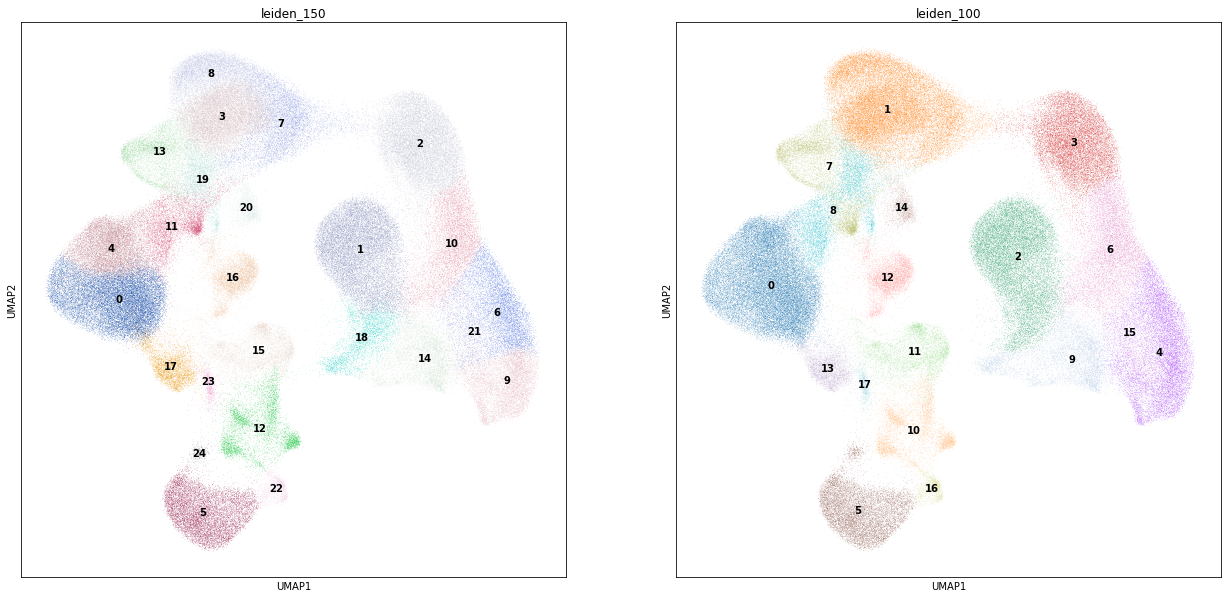

In [4]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150", "leiden_100"], legend_loc="on data")

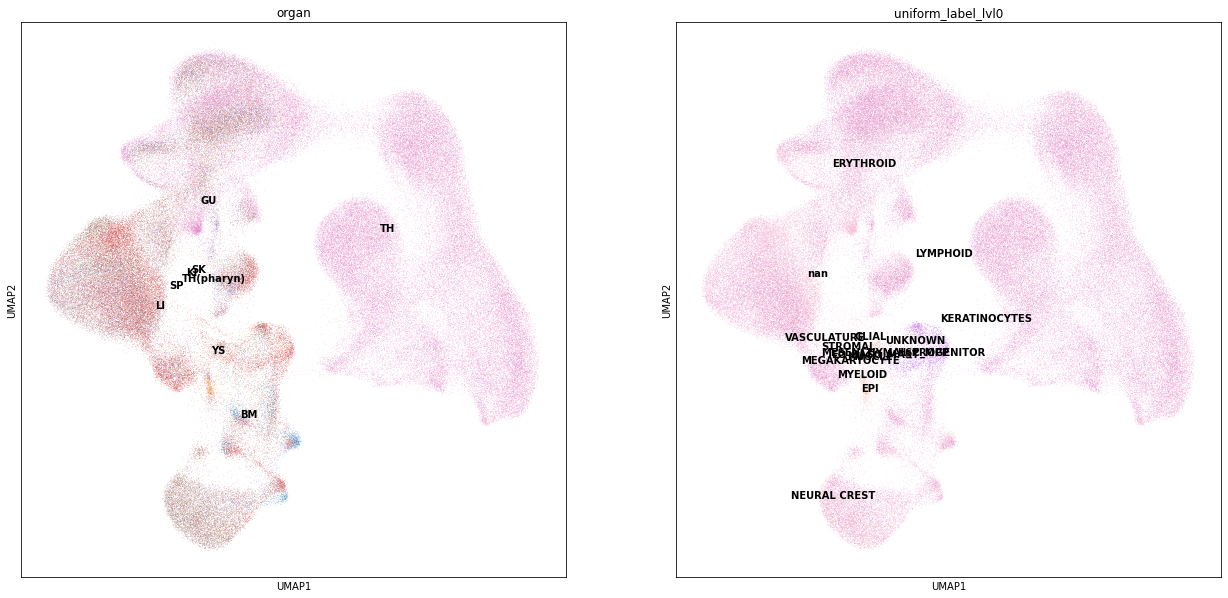

In [5]:
sc.pl.umap(adata, color=["organ", 'uniform_label_lvl0'], legend_loc="on data")

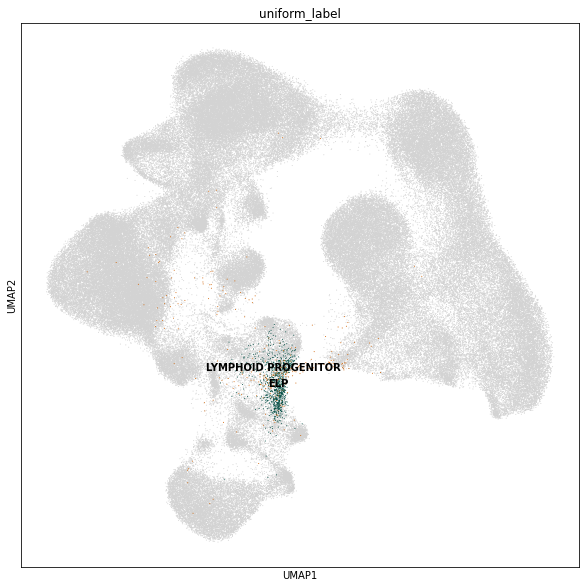

In [6]:
sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=["LYMPHOID PROGENITOR", "ELP"], size=4)

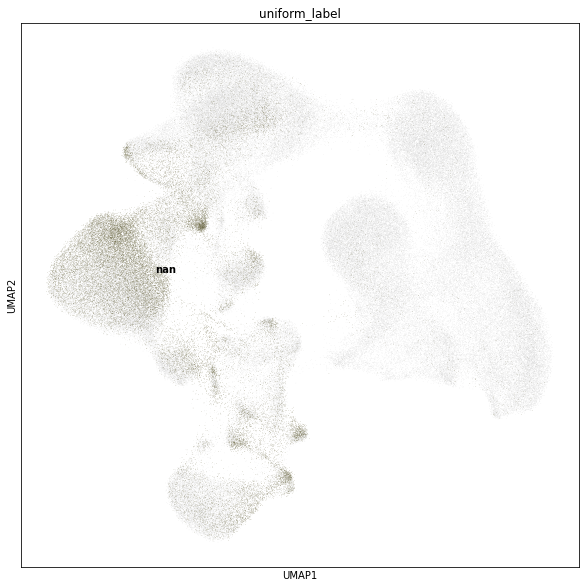

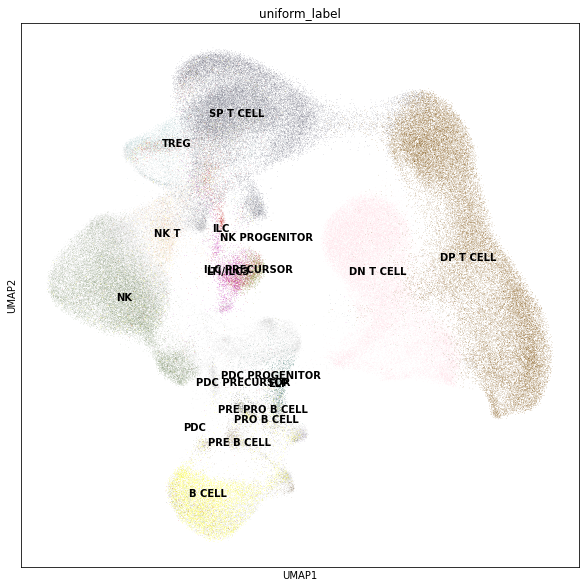

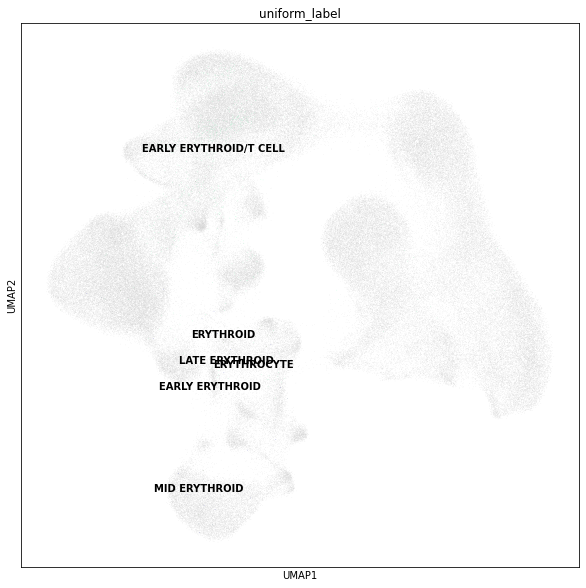

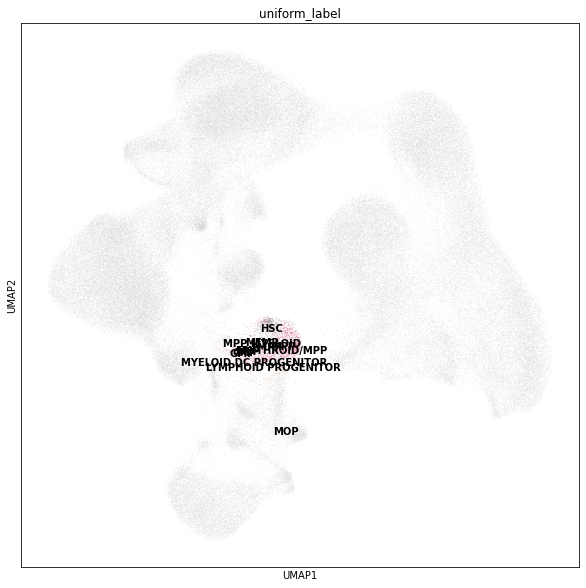

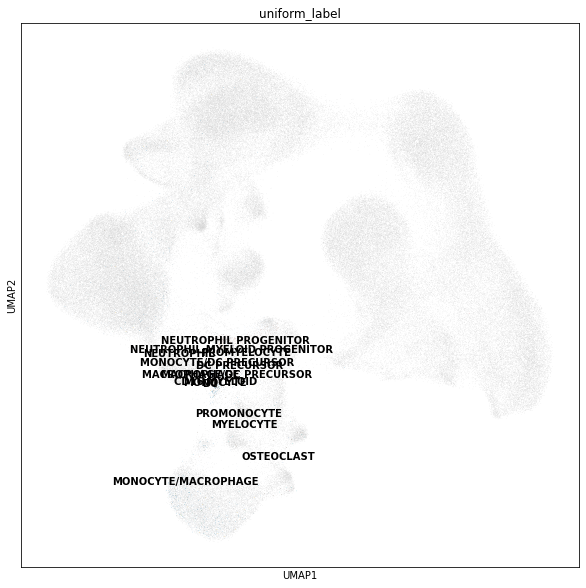

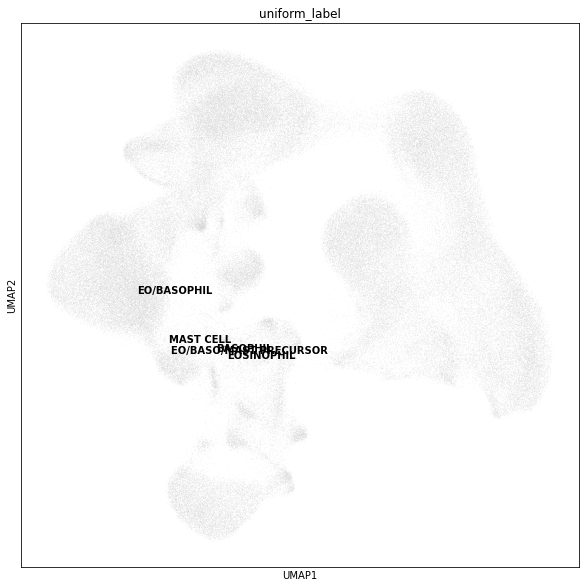

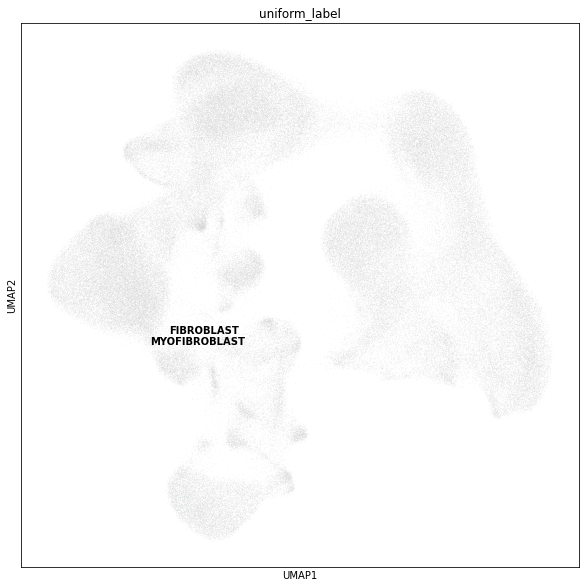

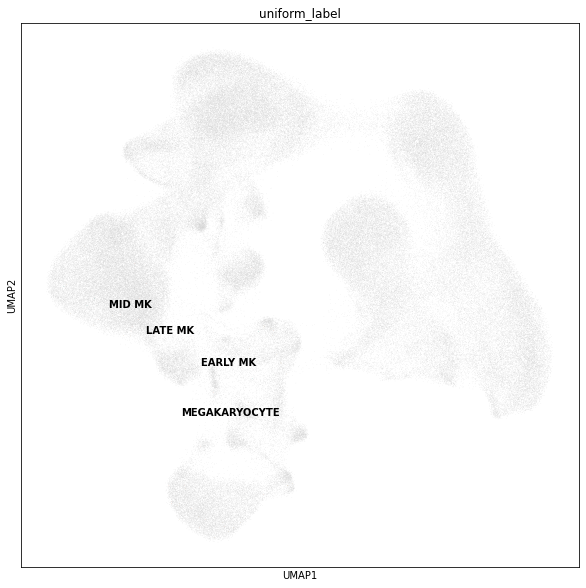

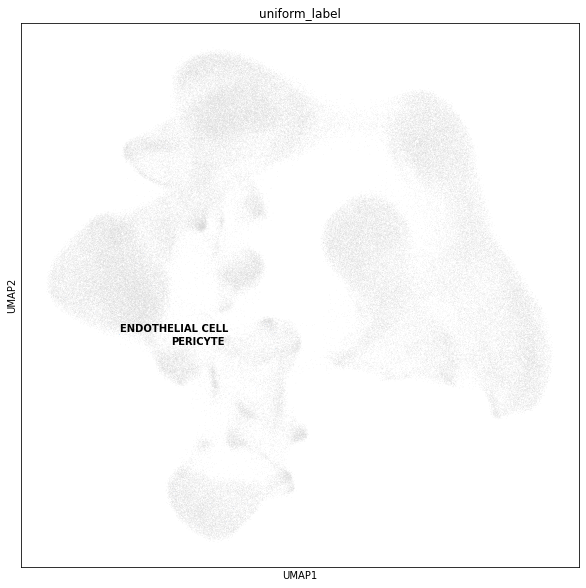

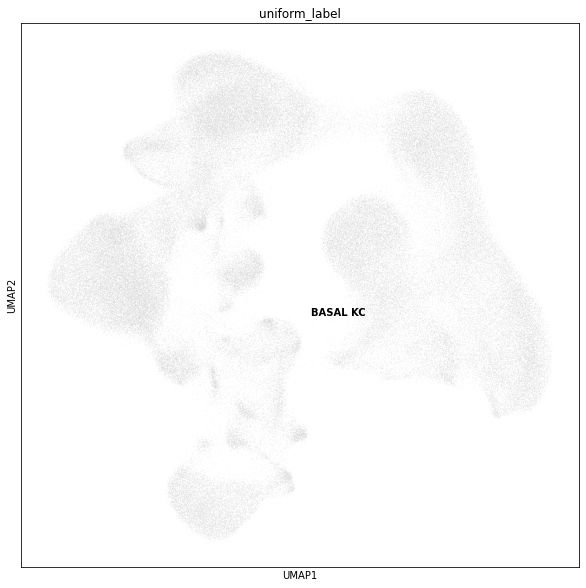

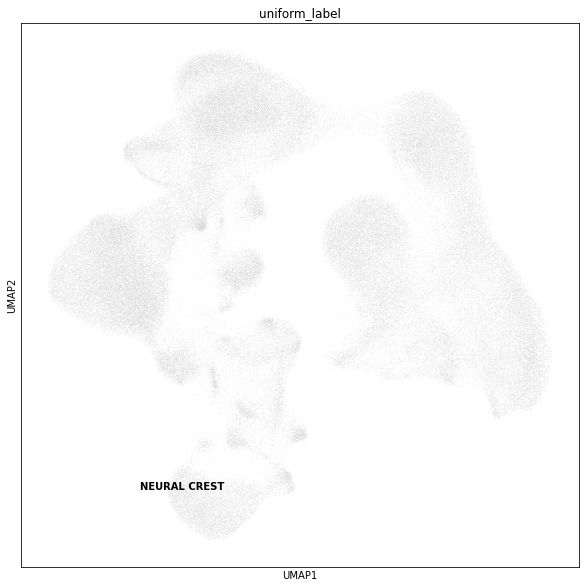

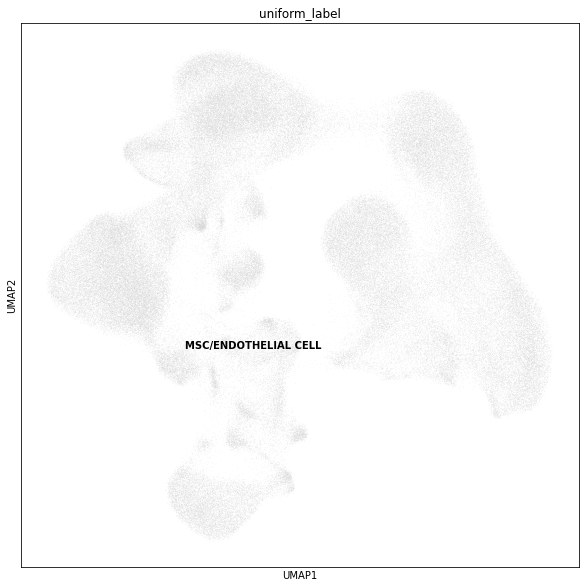

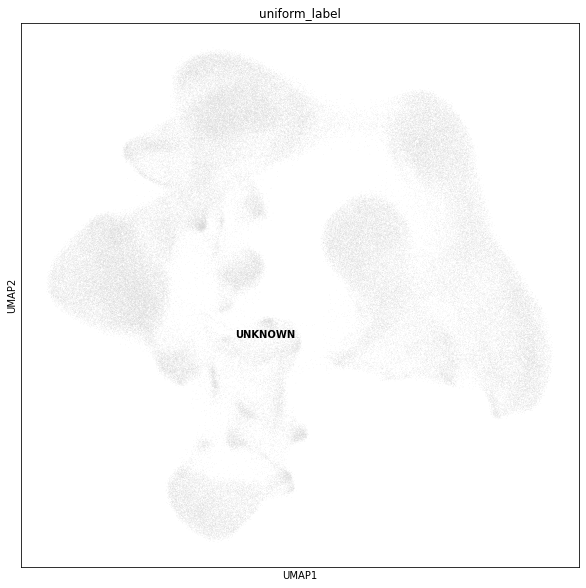

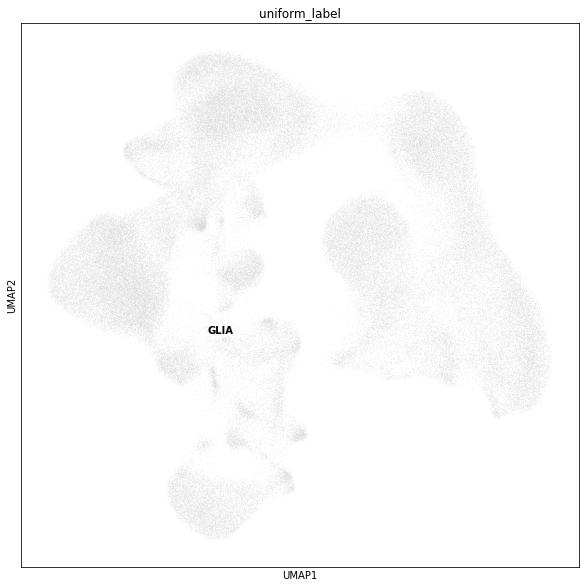

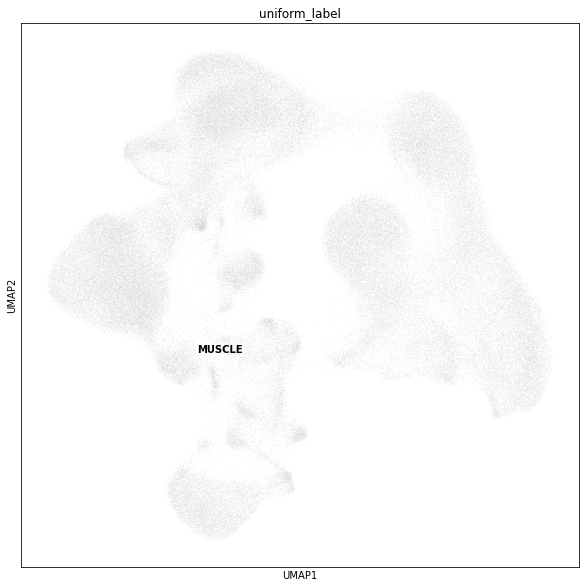

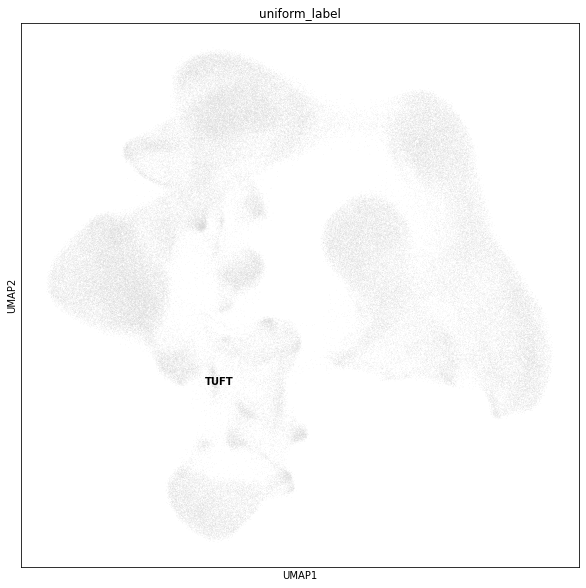

In [7]:
for o in adata.obs['uniform_label_lvl0'].unique():
    sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=adata.obs['uniform_label'][adata.obs['uniform_label_lvl0'] == o].unique())

### Annotate clusters using most frequent label 

In [8]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

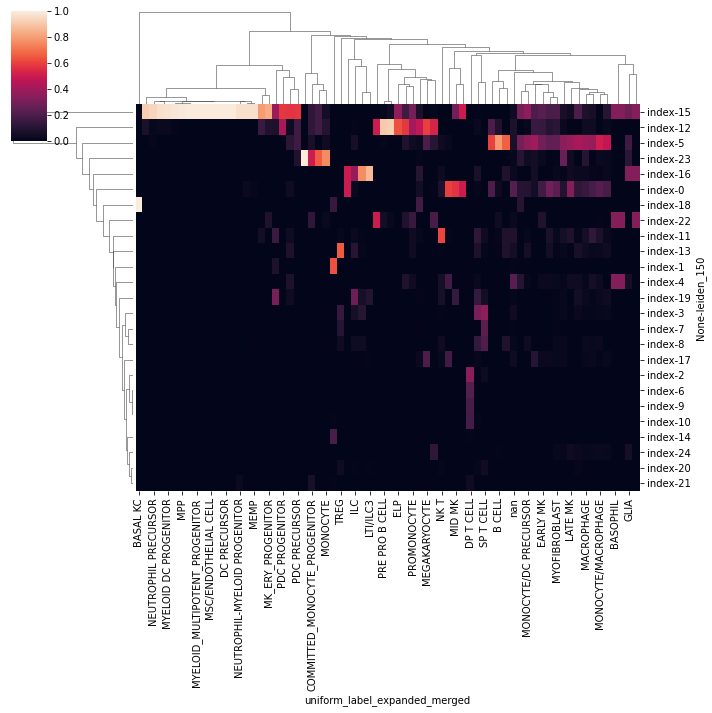

In [9]:
import seaborn as sns
sns.clustermap(cl_counts.T/cl_counts.sum(1))

... storing 'leiden_150_pred_label' as categorical


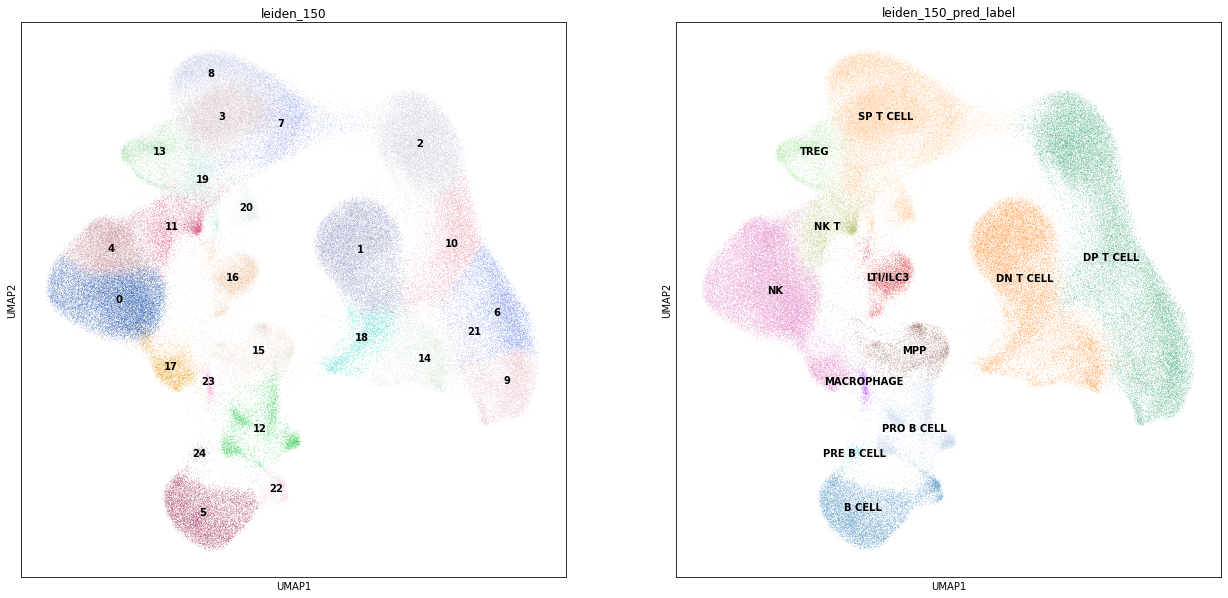

In [10]:
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")

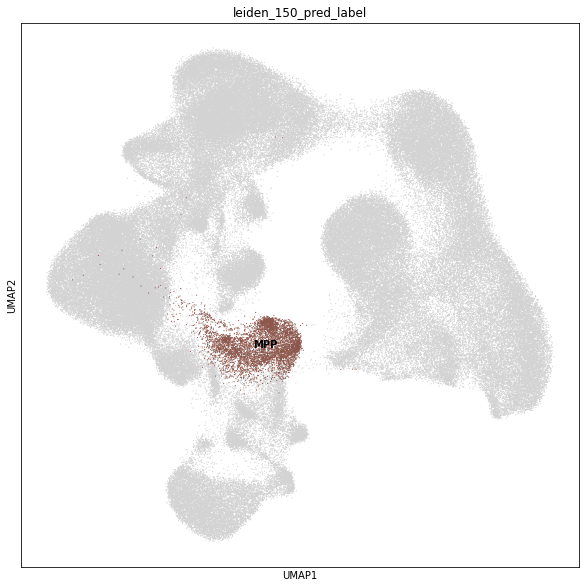

In [11]:
sc.pl.umap(adata, color=["leiden_150_pred_label"], legend_loc="on data", size=5, groups="MPP")

## Remove 'spill-over' clusters

In [25]:
spill_over = ["MACROPHAGE", "B CELL", "PRE B CELL", "PRO B CELL"]
obs_keep = adata.obs_names[~adata.obs["leiden_150_pred_label"].isin(spill_over)]

In [13]:
adata_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
# adata_raw = adata_raw[adata.obs_names]

In [19]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118'

In [26]:
s = "NKT_CLEAN"
adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
sdata = adata_raw[obs_keep]

In [30]:
print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
sdata.write_h5ad(adata_name)

Saving NKT_CLEAN anndata (159280 cells, 9 organs)
